# Group statistics of EEG/MEG data in sensor and source space

This example tests if evoked responses are significantly different between
two conditions across subjects. For demonstration purposes
we simulate data from multiple subjects using one subject's data, adding noise.
The multiple comparisons problem is addressed with a cluster-based
permutation test across space and time.
Note to self: "Statistics to the neuroimager is like the lamppost to the drunken sailor: It serves primarily for support, not for illumination".


In [1]:
# This notebook is based on MNE-Python tutorials and examples, e.g.
# https://mne.tools/stable/auto_tutorials/stats-sensor-space/20_erp_stats.html
# https://mne.tools/stable/auto_tutorials/stats-sensor-space/75_cluster_ftest_spatiotemporal.html
# https://mne.tools/stable/auto_tutorials/stats-source-space/20_cluster_1samp_spatiotemporal.html

# Modified by Olaf Hauk, olaf.hauk@mrc-cbu.cam.ac.uk
# These notebooks complement the online lectures "Introduction to EEG/MEG analysis":
# https://www.youtube.com/playlist?list=PLp67eqWCj2f_DBsCMkIOBpBbLWGAUKtu5

In [2]:
import numpy as np
from numpy.random import randn
from scipy import stats as stats
from matplotlib import pyplot as plt

import mne
from mne.datasets import sample
from mne.epochs import equalize_epoch_counts
from mne.minimum_norm import apply_inverse, read_inverse_operator
from mne.stats import spatio_temporal_cluster_1samp_test, summarize_clusters_stc

## Data and parameters:



In [3]:
data_path = sample.data_path()
meg_path = data_path / "MEG" / "sample"
raw_fname = meg_path / "sample_audvis_filt-0-40_raw.fif"
event_fname = meg_path / "sample_audvis_filt-0-40_raw-eve.fif"
subjects_dir = data_path / "subjects"
src_fname = subjects_dir / "fsaverage" / "bem" / "fsaverage-ico-5-src.fif"

tmin = -0.2
tmax = 0.3  # Use a lower tmax to reduce multiple comparisons

# Setup for reading the raw data
raw = mne.io.read_raw_fif(raw_fname)

events = mne.read_events(event_fname)

# create epochs for two conditions
event_ids = {'AL': 1, 'AR': 2, 'VL': 3, 'VR': 4}
epochs, evokeds = {}, {}

reject = dict(eog=150e-6)
for ee in event_ids:
    event_id = event_ids[ee]
    
    epochs[ee] = mne.Epochs(
        raw,
        events,
        event_id,
        tmin,
        tmax,
        baseline=(None, 0),
        reject=reject,
        preload=True,
    )

    evokeds[ee] = epochs[ee].average()

# create a "dataset" with multiple "subjects" by adding noise
n_sbjs = 10

# create a list of evokeds for each condition below
# we create one dataset with all channel types, and one with EEG-only to start with
dataset_ori, dataset = {}, {}
for ee in evokeds:
    dataset_ori[ee], dataset[ee] = [], []

for ee in evokeds:
    maxval = np.abs(evokeds[ee].data).max()
    # we have to add noise for channel types separately due to different scalings
    chidx = mne.channel_indices_by_type(evokeds[ee].info)
    for i in np.arange(n_sbjs):
        evoked = evokeds[ee].copy()
        for chtype in ['grad', 'mag', 'eeg']:
            m, n = evoked.data[chidx[chtype], :].shape
            evoked.data[chidx[chtype], :] += np.random.randn(m, n) * maxval / 3
        dataset_ori[ee].append(evoked.copy())
        dataset[ee].append(evoked.copy().pick(['eeg', 'eog']))

# Note: We call it 'dataset_ori' because we will reduce it to EEG-only in a moment,
# but want to keep all sensor types for later.

Opening raw data file /home/cognestic/COGNESTIC/08_EEG_MEG/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Not setting metadata
72 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 4)
4 projection items activated
Loading data for 72 events and 76 original time points ...
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  epoch based on EOG : ['EOG 061']
    Rejecting  

Let's just check how our noisy data look like, by plotting one of our noisy "subjects".

Projections have already been applied. Setting proj attribute to True.


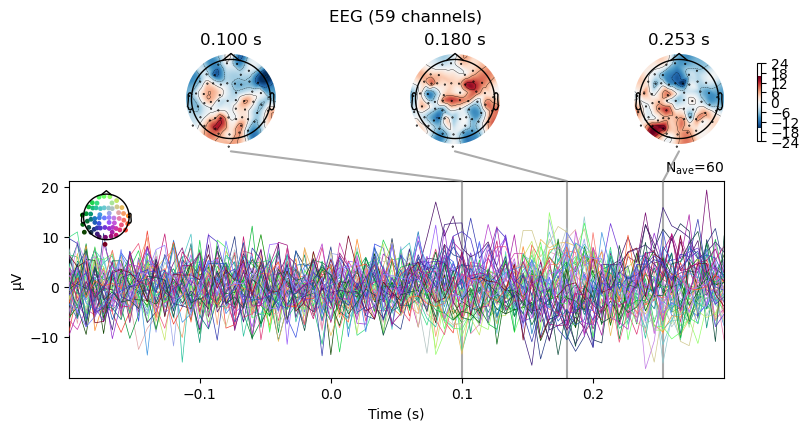

In [4]:
dataset[ee][0].plot_joint();

# Sensor space statistics

## ROI analysis in sensor space

For simplicity, let's say we are interested in laterality of visually evoked responses in posterior electrode groups.

We want to pick some electrode groups for sensor-level group statistics.

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 91.0 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 1 sensors
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 91.0 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 1 sensors
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 91.0 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 1 sensors
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 91.0 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 1 sensors
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 91.0 mm


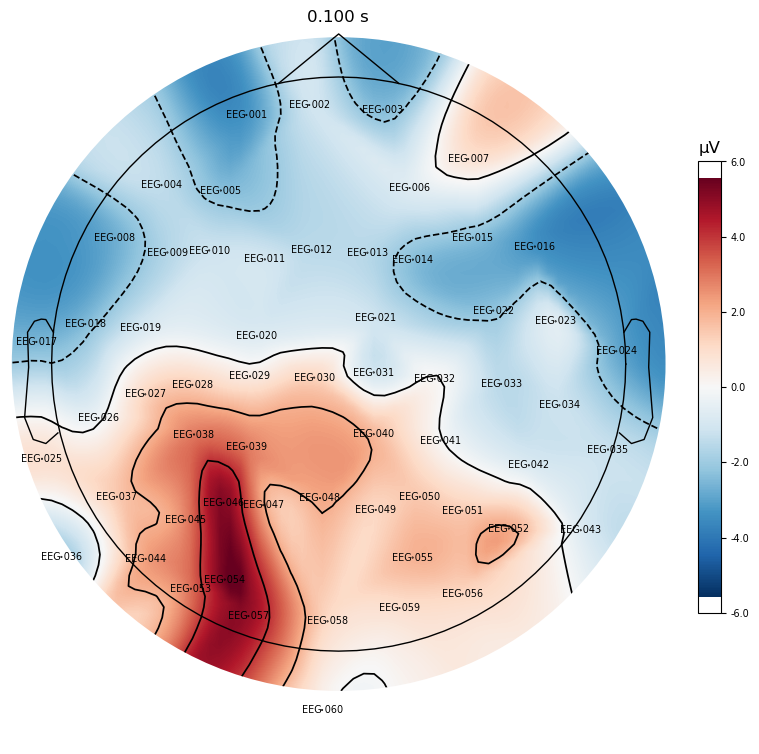

In [5]:
# We use the grand-average across conditions to avoid bias in electrode selection ("double-dipping").
# Let's plot a big-enough topography to see the channel names.
evoked = mne.grand_average(dataset['VL'] + dataset['VR'])
evoked.plot_topomap(times=[0.1], sensors=True, show_names=True, size=5);

Let's choose some electrodes for posterior left and right regions.

In [6]:
# note that capitals and spaces matter in the label names...
egroup = {'L': ['EEG 044', 'EEG 053', 'EEG 057'], 'R': ['EEG 043', 'EEG 052', 'EEG 055']}

# We also have some time windows of interest.
# Don't forget: We are using seconds, not milliseconds...
time_windows = ((0.08, 0.1), (0.15, 0.25))

Get data for electrode groups and latency windows and put them into a Pandas dataframe.

Then we can run statistics (here a simple t-test) and plot the results.

First, arrange data in a convenient dataframe.

In [7]:
import pandas as pd
from scipy.stats import ttest_ind

data = {'vals': [], 'cond': [], 'roi': [], 'lat': [], 'sbj': []}
for cc in dataset:
    for ee in egroup:
        for tt in time_windows:
            dat, cond, roi, lat = [], [], [], []
            for [si, ss] in enumerate(dataset[cc]):
                evo = ss.copy().crop(tt[0], tt[1]).pick(egroup[ee])
                data['vals'].append(np.mean(evo.data))
                data['cond'].append(cc)
                data['roi'].append(ee)
                data['lat'].append('%.0d' % (1000 * tt[0]))
                data['sbj'].append(si)

df = pd.DataFrame(data, index=data['sbj'])

Now define two conditions, run a t-test, and plot the results.

Left vs Right ROIs for Visual Left condition between 50-150ms: p=0.000002, t=-6.771395.


<Axes: xlabel='roi', ylabel='vals'>

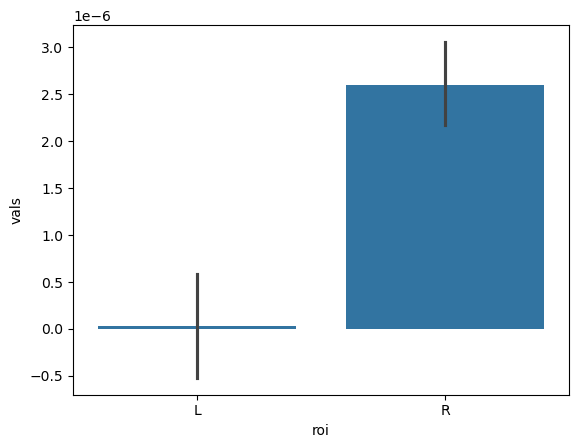

In [8]:
A = df.loc[(df['cond'] == 'VL') & (df['roi'] == 'L') & (df['lat'] == '80')]['vals']
B = df.loc[(df['cond'] == 'VL') & (df['roi'] == 'R') & (df['lat'] == '80')]['vals']

# quick t-test
t, p = ttest_ind(A, B)

print('Left vs Right ROIs for Visual Left condition between 50-150ms: p=%f, t=%f.' % (p, t))

import seaborn as sns

dfplot = df.loc[(df['cond'] == 'VL') & (df['lat'] == '80')]

sns.barplot(data=dfplot, x='roi', y='vals')

# Note: There may be better and more efficient ways to to this. But I hope this illustrates the general idea. 

## Cluster-based permutation tests in sensor space

In the example above we made a-priori choices about electrodes and latency ranges. But who knows what we may have missed?

If we take a more exploratory approach over space and/or time, we have to take multiple comparisons into account.

This reflects the trade-off between sensitivity and specificity for the more focussed versus the more exhaustive analysis.

More background on cluster-based permutation tests for EEG/MEG data can be found here: https://pubmed.ncbi.nlm.nih.gov/17517438/.

In [9]:
# In order to define clusters, we need to know which sensors are close to each other.
# Thus, we calculate an adjacency matrix between sensors from their locations.
adjacency, _ = mne.channels.find_ch_adjacency(evoked.info, "eeg")

conds = ['VL', 'VR']
X = []
for cond in conds:
    X.append([d.data for d in dataset[cond]])
X = np.array(X)

# X needs the dimension n_conditions x n_samples x n_timepoints x n_sensors
# here: 2 x 10 x ? x 60
# However, this is not the case yet. Our data are usually n_sensors x n_timepoints,
# so we have to transpose the last two dimensions
X = X.transpose(0, 1, 3, 2)

# set up the cluster based permutation
tfce = dict(start=0.4, step=0.4)  # ideally start and step would be smaller

# Calculate statistical thresholds
t_obs, clusters, cluster_pv, h0 = mne.stats.spatio_temporal_cluster_test(
    X, tfce, adjacency=adjacency, n_permutations=100
)  # a more standard number would be 1000+
significant_points = cluster_pv.reshape(t_obs.shape).T < 0.05
print(str(significant_points.sum()) + " points selected by TFCE ...")

Could not find a adjacency matrix for the data. Computing adjacency based on Delaunay triangulations.
-- number of adjacent vertices : 60
stat_fun(H1): min=2.015998797083603e-08 max=100.01502447864955
Running initial clustering …
Using 250 thresholds from 0.40 to 100.00 for TFCE computation (h_power=2.00, e_power=0.50)
Found 4560 clusters


  0%|          | Permuting : 0/99 [00:00<?,       ?it/s]

293 points selected by TFCE ...


We can indicate significant clusters for electrode groups over time.

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 91.0 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 1 sensors
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 91.0 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 1 sensors
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 91.0 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 1 sensors
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 91.0 mm
Computing interpolation matrix from 59 sensor positions
Interpolating 1 sensors
Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 91.0 mm


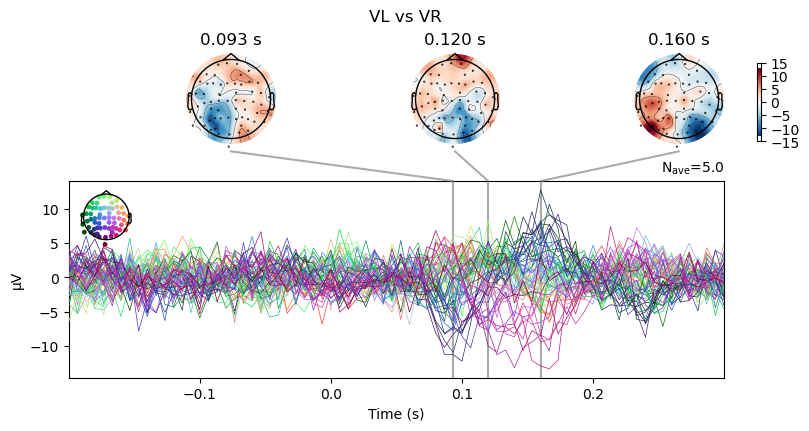

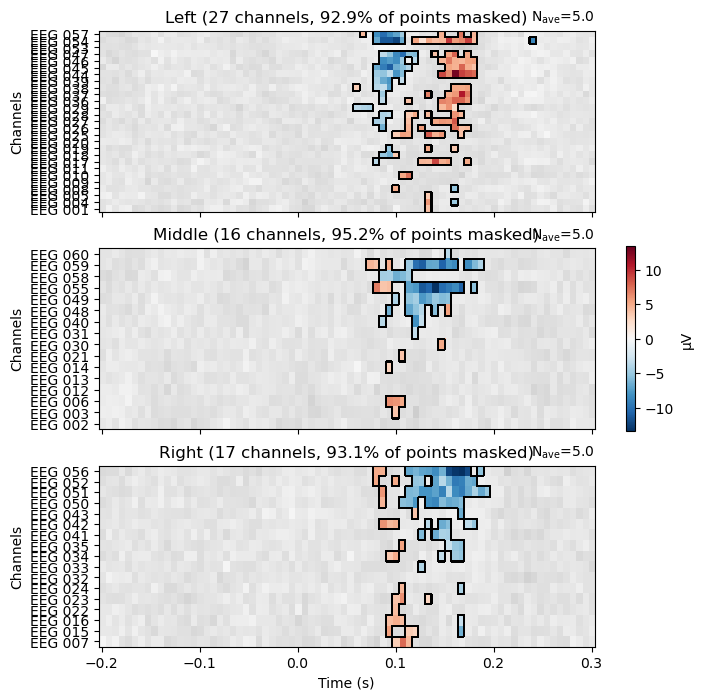

In [10]:
evoked1 = mne.grand_average(dataset[conds[0]])  # grand-averages per condition
evoked2 = mne.grand_average(dataset[conds[1]])
evoked = mne.combine_evoked([evoked1, evoked2], [1, -1])  # subtract data

time_unit = dict(time_unit="s")
evoked.plot_joint(
    title="%s vs %s" % (conds[0], conds[1]), ts_args=time_unit, topomap_args=time_unit
)  # show difference wave

# create electrode selections based on their coordinates
xs = np.array([evoked.info['chs'][i]['loc'][0] for i in np.arange(len(evoked.info['chs']))])  # left/right coordinate
selections = {
    'Left': np.where(xs < -0.03)[0],
    'Middle': np.where((xs >= -0.03) & (xs <= 0.03))[0],
    'Right': np.where(xs > 0.03)[0]
}

# Visualize the results
fig, axes = plt.subplots(nrows=3, figsize=(8, 8))
axes = {sel: ax for sel, ax in zip(selections, axes.ravel())}
evoked.plot_image(
    axes=axes,
    group_by=selections,
    colorbar=False,
    show=False,
    mask=significant_points,
    show_names="all",
    titles=None,
    **time_unit,
)
plt.colorbar(axes["Left"].images[-1], ax=list(axes.values()), shrink=0.3, label="µV")

plt.show()

Or we can plot topographies over time and mark the significant sensors:

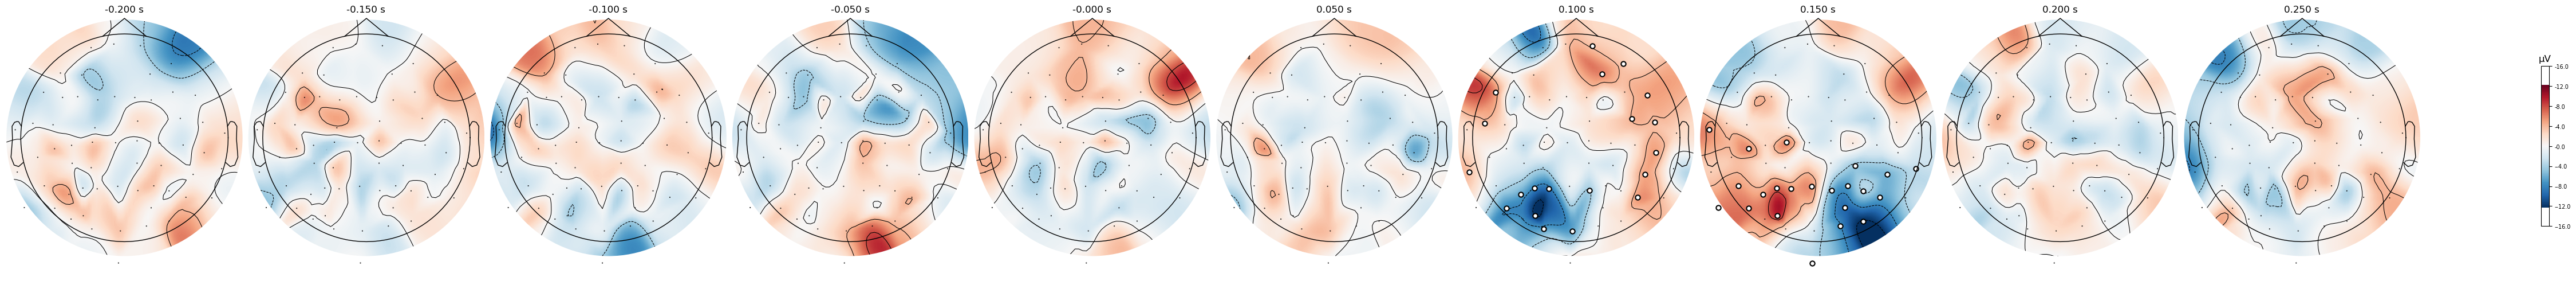

In [11]:
fig = evoked.plot_topomap(
    ch_type='eeg',
    times=np.arange(-0.2, 0.3, 0.05),
    cbar_fmt="-%0.1f",
    mask=significant_points,
    size=3,
    show_names=False,
    time_unit="s",
)

**Question:** The evoked responses around 100-200ms are clearly significant, which is not surprising. What about smaller clusters elsewhere (depends on noise)?

## Cluster-based permutation tests in source space

We can apply source estimation to the "dataset" above and then run very similar statistical analyses.

Here, we add noise in source space, i.e. after applying the inverse operator, rather than applying it to noisy evoked data created above. This is because the (random, uncorrelated) noise does not fit to the noise covariance matrix used when creating the inverse operator, i.e. our source estimates wouldn't be reliable.

In [12]:
fname_inv = meg_path / "sample_audvis-meg-oct-6-meg-inv.fif"
inverse_operator = read_inverse_operator(fname_inv)
sample_vertices = [s["vertno"] for s in inverse_operator["src"]]

snr = 3.0
lambda2 = 1.0 / snr**2
method = "MNE"  # use dSPM method (could also be MNE, sLORETA, or eLORETA)

# In the following, we will do something very inefficient: # we loop through all subjects
# per condition, but apply the inverse operator to the same # evoked data every time. 
# This is just to illustrate how this may look like for a real # experiment.

datasetstc = {}
for cond in dataset:
    datasetstc[cond] = []
    #  We cropd the evoked data, resulting in fewer multiple comparisons and faster computation.
    evoked = evokeds[cond].copy().crop(0.05, 0.2)
    for dummy in dataset[cond]:
        stc = apply_inverse(evoked, inverse_operator, lambda2, method, pick_ori=None)
        maxval = np.abs(stc.data).max()
        m, n = stc.data.shape
        stc.data = stc.data + np.random.randn(m, n) * maxval / 5
        datasetstc[cond].append(stc)


Reading inverse operator decomposition from /home/cognestic/COGNESTIC/08_EEG_MEG/MNE-sample-data/MEG/sample/sample_audvis-meg-oct-6-meg-inv.fif...
    Reading inverse operator info...
    [done]
    Reading inverse operator decomposition...
    [done]
    305 x 305 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Noise covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 2) found.
    Source covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 6) found.
    Orientation priors read.
    22494 x 22494 diagonal covariance (kind = 5) found.
    Depth priors read.
    Did not find the desired covariance matrix (kind = 3)
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
 

We can quickly check whether our creating looks reasonable - let's plot the grand-average for one condition.

In [13]:
stcgm = np.average(datasetstc[cond])  # note you can use numpy methods on STC objects
stcgm.plot(subjects_dir=subjects_dir, subject='sample', hemi='both', initial_time=0.1)

Using pyvistaqt 3d backend.
Using control points [4.22669029e-10 4.65878161e-10 1.44113430e-09]
True


## Transform to common cortical space

In order to do group statistics we have to morph (normalize)
the invidual source spaces to the same cortical space (e.g., fsaverage). 

In [14]:
# the source to  morph to (Freesurfer's fsaverage)
fname_fsaverage_src = subjects_dir / "fsaverage" / "bem" / "fsaverage-ico-5-src.fif"
src_to = mne.read_source_spaces(fname_fsaverage_src)

# All our "subjects" are the same (sample dataset), so we only need one morphing matrix.
# In real studies, this has to be done for each individual subject.
# If you are not using individual MRIs, and already use the fsaverage source space,
# then you don't have to worry about this at all.
morph = mne.compute_source_morph(
    datasetstc[cond][0],
    subject_from="sample",
    subject_to="fsaverage",
    src_to=src_to,
    subjects_dir=subjects_dir,
)

# We have to apply the morphing matrix to all data.
# Note that we replace the original STCs since we won't need them anymore.
datasetmorph = {}
for cond in datasetstc:
    datasetmorph[cond] = [morph.apply(stc) for stc in datasetstc[cond]]

    Reading a source space...
    [done]
    Reading a source space...
    [done]
    2 source spaces read
surface source space present ...
Computing morph matrix...
    Left-hemisphere map read.
    Right-hemisphere map read.
    17 smooth iterations done.
    14 smooth iterations done.
[done]
[done]


Similar to before, let's plot the morphed grand-average to make sure it looks plausible.

In [15]:
stcgm = np.average(datasetmorph[cond])
stcgm.plot(subjects_dir=subjects_dir, subject='fsaverage', hemi='both', initial_time=0.1)
# Note: Here we have to specificy 'fsaverage' as subject.

Using control points [2.86553587e-10 3.33281100e-10 1.53357650e-09]
True


Now we have to create a design matrix X that contains our data for all conditions, subjects, and dimensions of interest (here: space and time) in the right order.

In [16]:
X = []
# we will contrast two conditions with t-tests
for cond in ['AL', 'VR']:
    X.append(np.array([stc.data.transpose() for stc in datasetmorph[cond]]))
# Note: We transposed the data matrix. We usually use data with dimensions
# n_space x n_time, but in the following we will need it the other way round (sorry).

# X contains the two conditions as two separate lists.
# The data per condition have dimension n_observations (subjects) × n_time × n_space.

print(len(X))
print(X[0].shape)

2
(10, 23, 20484)


### Find adjacency matrix

For cluster-based permutation testing, we must define adjacency relations
that govern which points can become members of the same cluster. While
these relations are rather obvious for dimensions such as time or frequency
they require a bit more work for spatial dimension such as channels or
source vertices.

Here, to use an algorithm optimized for spatio-temporal clustering, we
just pass the spatial adjacency matrix (instead of spatio-temporal).
But note that clustering still takes place along the
temporal dimension and can be
controlled via the ``max_step`` parameter in
:func:`mne.stats.spatio_temporal_cluster_1samp_test`.

If we wanted to specify an adjacency matrix for both space and time
explicitly we would have to use :func:`mne.stats.combine_adjacency`,
however for the present case, this is not needed.



In [17]:
# Note we are using 'src_to', i.e. the morphed source space.
adjacency = mne.spatial_src_adjacency(src_to)

-- number of adjacent vertices : 20484


### Compute statistic
We compute mass-univariate paired two-sample t-tests. This can take a while.



In [18]:
X = X[0] - X[1]  # make paired contrast

# Here we set a cluster forming threshold based on a p-value for
# the cluster based permutation test.
# We use a two-tailed threshold, the "1 - p_threshold" is needed
# because for two-tailed tests we must specify a positive threshold.
n_subjects = X[0].shape[0]
p_threshold = 0.001
df = n_subjects - 1  # degrees of freedom for the test
t_threshold = stats.distributions.t.ppf(1 - p_threshold / 2, df=df)

# Now let's actually do the clustering. This can take a long time...
print("Clustering.")
T_obs, clusters, cluster_p_values, H0 = clu = spatio_temporal_cluster_1samp_test(
    X,
    adjacency=adjacency,
    n_jobs=None,
    threshold=t_threshold,
    buffer_size=None,
    verbose=True,
)

Clustering.
stat_fun(H1): min=-31.95761435281662 max=16.395303714986895
Running initial clustering …
Found 2046 clusters


  0%|          | Permuting (exact test) : 0/511 [00:00<?,       ?it/s]

## Visualize the clusters



You may wish to select the observed clusters that can be considered statistically significant under the permutation distribution. However, be aware that a statistically significant observed cluster does not directly translate into statistical significance of the channels, time points, frequency bins, etc. that form the cluster!

For more information, see the [Fieldtrip tutorial](https://www.fieldtriptoolbox.org/tutorial/stats/cluster_permutation_timelock/) or [this paper](https://onlinelibrary.wiley.com/doi/full/10.1111/psyp.13335).

The next step visualises cluster in terms of their temporal extent.

In [19]:
print("Visualizing clusters.")

# Now let's build a convenient representation of our results, where consecutive
# cluster spatial maps are stacked in the time dimension of a SourceEstimate
# object. This way by moving through the time dimension we will be able to see
# subsequent cluster maps.
tstep = datasetmorph[cond][0].tstep * 1000  # convert to milliseconds
fsave_vertices = [s["vertno"] for s in src_to]
stc_all_cluster_vis = summarize_clusters_stc(
    clu, tstep=tstep, vertices=fsave_vertices, subject="fsaverage"
)

# Let's actually plot the first "time point" in the SourceEstimate, which
# shows all the clusters, weighted by duration.

# blue blobs are for condition A < condition B, red for A > B
maxval = np.abs(stc_all_cluster_vis.data).max()
brain = stc_all_cluster_vis.plot(
    hemi="both",
    views="lateral",
    subjects_dir=subjects_dir,
    subject='fsaverage',
    time_label="temporal extent (ms)",
    size=(800, 800),
    smoothing_steps=5,
    clim={'kind': 'value', 'pos_lims': (0, maxval/2, maxval)},
    initial_time=0.
)

# We could save this via the following:
# brain.save_image('clusters.png')

Visualizing clusters.
True


Not surprisingly, auditory stimuli evoked more activity in temporal brain areas and visual stimuli in poster areas.


We may also want to plot activation values __masked by significant clusters__. Here we create a mask:

In [20]:
# Select the clusters that are statistically significant at p < 0.05
good_clusters_idx = np.where(cluster_p_values < 0.05)[0]
good_clusters = [clusters[idx] for idx in good_clusters_idx]

Xdiffmean = X.mean(axis=0).T  # mean over "subjects

# zeros at all vertices...
mask = np.zeros(Xdiffmean.shape)

# ...except the significant ones:
for g in good_clusters:
    mask[g[1], g[0]] = 1

We apply the mask and plot the distribution:

In [21]:
stc_masked = datasetmorph[cond][0]  # take one STC
stc_masked.data = Xdiffmean * mask  # apply the mask

maxval = np.abs(stc_masked.data).max()
brain = stc_masked.plot(
    hemi="both",
    views="lateral",
    subjects_dir=subjects_dir,
    subject='fsaverage',
    time_label="Activation (masked)",
    size=(800, 800),
    smoothing_steps=5,
    clim={'kind': 'value', 'pos_lims': (0, maxval/2, maxval)},
    initial_time=0.1
)

True


**Exercise**:<br>
- Try different cluster thresholds.

You will have to choose the right statistical design for your analysis. Take care to test for interactions properly and avoid "erroneous interaction analysis": If only one of two comparisons is significant (e.g. the difference between auditory and visual conditions is significant in the left but not the right hemisphere), you cannot conclude that there is a significant interaction between the factors (in the example Hemisphere-by-Condition. See https://www.nature.com/articles/nn.2886).

Also note that "Cluster-based permutation tests of MEG/EEG data do not establish significance of effect latency or location" (https://pubmed.ncbi.nlm.nih.gov/30657176/). A significant cluster indicates that "something is significant within the cluster", but it doesn't allow inferences about individual voxels, such as those at the border of the cluster.